<a href="https://colab.research.google.com/github/claudiosegala/Monografia/blob/master/code/tcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC

## Models

- Random Guess
- Mean
- Random Forest
- RNN
- LSTM
- GRU

## Evaluation

- RMSE
- NRMSE
  - Normalized by stardartization

# Mount Drive

Connect to Google Drive of 'alfredcoinworth'

In [47]:
import google as g # To connect with google drive
g.colab.drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Instanciate Dependencies


In [48]:
!pip install tensorflow
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install sklearn
!pip install keras
!pip install statsmodels

In [0]:
import tensorflow as tf # machine learning library
import pandas as pd # data manipulation library
import matplotlib.pyplot as plt # plot library
import numpy as np # math library
import datetime as dt # to discover week day
import time as tm # to convert to seconds
import sklearn as skl # regression templates library
import sklearn.metrics as sklm # metrics
import statsmodels.api as sma # statistical models api
import statistics as st # statistics
import statsmodels as sm # statistical models

import math
import json
import copy

from sklearn.preprocessing import MinMaxScaler

# Configurations


## Tensorflow

In [0]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Paths

In [0]:
# Colab
TCC_PATH = '/content/drive/My Drive/TCC/'

# Local
# TCC_PATH = ''

## Parametes

In [0]:
SEEABLE_PAST = 180 # in minutes

PREDICT_IN_FUTURE = 15 # in minutes

FLOW_INTERVAL = 450 # the interval size for each flow

NORMALIZE_FEATS = False #Decide if we gonna use normalized flow and speed values, or not

SET_SPLIT = 0.75

TEST_SPLIT = 0.2

VALIDATION_SPLIT = 0.2

VERBOSITY = False


# Derivated

N_STEPS = SEEABLE_PAST * 60 // FLOW_INTERVAL # the number of flows to see in the past

N_FUTURE = PREDICT_IN_FUTURE * 60 // FLOW_INTERVAL # how much in the future we want to predict (0 = predict the flow on the next 5 minutes)

DAY_SIZE = (24 * 3600) // FLOW_INTERVAL  

WEEK_SIZE = 7 * DAY_SIZE

## Global

In [0]:
result_data = {
    'results': {},
    'meta': {}
}

In [0]:
comparison_data = []

# Util

## Data


In [0]:
# split_sequence([1, 2, 3, 4, 5], 3) #=> ([[1, 2, 3], [2, 3, 4]], [4, 5])
def split_sequence(sequence, isMulti):
  n = len(sequence)
  X, Y = list(), list()
  
  for i in range(n):
    j = i + N_STEPS
    k = j + N_FUTURE

    if k >= n:
      break

    seq_x, seq_y = sequence[i:j], sequence[k]
    X.append(seq_x)
    Y.append(seq_y[0] if isMulti else seq_y)

  return np.array(X), np.array(Y)

In [0]:
def reshape_flow (raw_seq, isMulti):  
  # split into samples
  X, Y = split_sequence(np.array(raw_seq), isMulti)
  
  print(X.shape)
  
  if not isMulti: # reshape from [samples, timesteps] into [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))

  return X, Y

## Plot

In [0]:
def plot_history (history, name):
  path = f"{TCC_PATH}plots/histories/{name}"
  
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(name + ' Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.rcdefaults()
  
  plt.savefig(path + ".png", bbox_inches='tight')
  plt.savefig(path + ".pdf")
  
  #plt.show(name + "ind")
  plt.close('all')

In [0]:
def plot_prediction (Y, Y_hat, title):
  flatten = lambda l: [i for sl in l for i in sl]
  
  n = math.floor(len(Y) / DAY_SIZE)
  Y = flatten(Y)
  Y_hat = flatten(Y_hat)
  
  for r in range(n):
    i = r * DAY_SIZE
    j = min(i + DAY_SIZE, len(Y))
    
    path = f"{TCC_PATH}plots/predictions/{title} ({str(r+1).zfill(2)} of {n})"
    
    plt.plot(Y[i:j])
    plt.plot(Y_hat[i:j])
    plt.title(title + 'Prediction')
    plt.ylabel('Flow')
    plt.xlabel('Time')
    plt.legend(['actual', 'prediction'], loc='upper left')
    plt.rcdefaults()

    plt.savefig(path + ".png", bbox_inches='tight')
    plt.savefig(path + ".pdf")

    plt.close('all')

In [0]:
def plot_performance_bar(i, y_label, title):
  path = f"{TCC_PATH}plots/performances/bars/{title}"
  
  models = tuple(results.keys())
  y_pos = np.arange(len(models))
  performance = [sum(v[i]) / len(v[i]) for v in results.values()]

  plt.rcdefaults()
  plt.bar(y_pos, performance, align='center', alpha=0.5)
  plt.xticks(y_pos, models)
  plt.ylabel(y_label)
  plt.title(title)

  plt.savefig(path + ".png", bbox_inches='tight')
  plt.savefig(path + ".pdf")
  
  plt.show()
  plt.close('all')

In [0]:
def plot_performance_box(i, y_label, title):
  path = f"{TCC_PATH}plots/performances/boxes/{title}"
  
  fig, ax_plot = plt.subplots()
  
  ax_plot.set_title(title)
  ax_plot.set_xlabel('Model')
  ax_plot.set_ylabel(y_label)
  
  bplot = ax_plot.boxplot([v[i] for v in results.values()])
  ax_plot.set_xticklabels(list(results.keys()))
  
  plt.savefig(path + ".png", bbox_inches='tight')
  plt.savefig(path + ".pdf")
  
  plt.show()
  plt.close('all')

## Model


In [0]:
from keras.models import Sequential
from keras.layers import Dense

In [0]:
def split_dataset (n):
  window_size = int(n * SET_SPLIT)
  test_size = int(window_size * TEST_SPLIT)
  jump_size = test_size
  train_size = window_size - test_size
    
  i, j, k = 0, train_size, min(n, train_size + test_size)
  
  res = []
  
  while j < n:
    res.append((i, j, k))
    
    i = i + jump_size
    j = i + train_size
    k = min(n, j + test_size)
    
  return res

In [0]:
def hit_ratio (Y, Y_hat):
  cnt = 0
  
  for i in range(len(Y)):
    if i == 0:
      continue
      
    exp = Y[i] - Y[i-1]
    obs = Y_hat[i] - Y_hat[i-1]
    
    if exp * obs > 0:
      cnt += 1
    
  return cnt / len(Y)
    

In [0]:
def precision (Y, Y_hat):
  n_buckets = 7;
  buckets = [0] * n_buckets
  
  for i in range(len(Y)):
    diff = abs(Y[i] - Y_hat[i])
    
    for i in range (n_buckets):
      if diff <= 2**i:
        buckets[i] += 1
        break

  for i in range (n_buckets):
     buckets[i] = buckets[i] / len(Y)

  return tuple(buckets)

In [0]:
def evaluate (expected, observed, times, title):
  global result_data
  
  n = len(expected)
  
  expected = list(map(list, expected))
  observed = list(map(list, observed))
  
  # Make the arrays serializable
  for i in range(n):
    expected[i] = list(map(float, expected[i]))
    observed[i] = list(map(float, observed[i]))

  
  if NORMALIZE_FEATS:
    for i in range(n):
      expected[i] = list(scaler.inverse_transform(expected[i]))
      observed[i] = list(scaler.inverse_transform(observed[i]))
  
  result_data['results'][title] = {
    'TIME': 0,
    'RMSE': 0.0,
    'NRMSE': 0.0,
    'MAE': 0.0,
    'R2': 0.0,
    'HR': 0.0,
    'PRE': [],
    'raw': {
      'expected': expected,
      'observed': observed,
      'execution_time': times,
      'RMSE': [0] * n,
      'NRMSE': [0] * n,
      'MAE': [0] * n,
      'R2': [0] * n,
      'HR': [0] * n,
      'PRE': [0] * n,
    }
  }
  
  eva = result_data['results'][title]
  raw = result_data['results'][title]['raw']
  
  for i in range(n):
    Y = expected[i]
    Y_hat = observed[i]
    time = times[i]

    raw['MAE'][i] = sklm.mean_absolute_error(Y, Y_hat)
    raw['RMSE'][i] = np.sqrt(sklm.mean_squared_error(Y, Y_hat))
    raw['NRMSE'][i] = raw['RMSE'][i] / np.std(Y)
    raw['R2'][i] = sklm.r2_score(Y, Y_hat)
    raw['HR'][i] = hit_ratio(Y, Y_hat)
    raw['PRE'][i] = precision(Y, Y_hat)
    
    if VERBOSITY:
      print(f"({i+1}/{n}) Test Size: {len(Y)}, Time: {time}s, RMSE: {raw['RMSE'][i]}, NRMSE: {raw['NRMSE'][i]}, MAE: {raw['MAE'][i]}, R2: {raw['R2'][i]}, Hit Ratio: {raw['HR'][i] * 100}%")
    
  eva['TIME'] = int(sum(times))
  eva['RMSE'] = sum(raw['RMSE']) / len(raw['RMSE'])
  eva['NRMSE'] = sum(raw['NRMSE']) / len(raw['NRMSE'])
  eva['MAE'] = sum(raw['MAE']) / len(raw['MAE'])
  eva['R2'] = sum(raw['R2']) / len(raw['R2'])
  eva['HR'] = sum(raw['HR']) / len(raw['HR'])
  eva['PRE'] = list(map(sum, zip(*raw['PRE'])))
      
  if VERBOSITY:
    plot_prediction(expected, observed, title)
    print(f"=> Total Time: {eva['TIME']}s, RMSE: {eva['RMSE']}, NRMSE: {eva['NRMSE']}, MAE: {eva['MAE']}, R2: {eva['R2']}, Hit Ratio: {eva['HR'] * 100}%, Precision: {eva['PRE']}")

## Storage

In [0]:
def print_json ():
  print(json.dumps(result_data, sort_keys=True, indent=4))

In [0]:
def store_results ():
  name = int(tm.time())
  
  result_data['meta'] = {
    "SEEABLE_PAST": SEEABLE_PAST,
    "PREDICT_IN_FUTURE": PREDICT_IN_FUTURE,
    "FLOW_INTERVAL": FLOW_INTERVAL,
    "NORMALIZE_FEATS": NORMALIZE_FEATS,
    "SET_SPLIT": SET_SPLIT,
    "TEST_SPLIT": TEST_SPLIT,
    "VALIDATION_SPLIT": VALIDATION_SPLIT,
  }
  
  with open(f"{TCC_PATH}results/{name}.json", 'w') as json_file:
    json.dump(result_data, json_file)
    
  slim_result_data = copy.deepcopy(result_data)
  for model in slim_result_data['results']:
      del slim_result_data['results'][model]['raw']
    
    
  with open(f"{TCC_PATH}results/{name}_slim.json", 'w') as json_file:
    json.dump(slim_result_data, json_file)

In [0]:
def store_comparisons ():
  name = int(tm.time())
  
  with open(f"{TCC_PATH}results/comparison/{name}.json", 'w') as json_file:
    json.dump(comparison_data, json_file)
    
  slim_comparison_data = copy.deepcopy(comparison_data)
  for i in range(len(slim_comparison_data)):
    print([*slim_comparison_data[i]['results']])
    for model in slim_comparison_data[i]['results']:
      del slim_comparison_data[i]['results'][model]['raw']
    
    
  with open(f"{TCC_PATH}results/comparison/{name}_slim.json", 'w') as json_file:
    json.dump(slim_comparison_data, json_file)

# Dataset Generation

This phase we have to get the data stored in Google Drive and transform into a dataset for prediction.


## Retrieval

In [0]:
col_names = ['Sensor', 'Date', 'Time', 'Lane', 'Speed', 'Max Speed', 'Size']
all_data = pd.read_csv(f"{TCC_PATH}dataset/all_data_sorted.csv", ';', header=None, names=col_names)

In [70]:
all_data.head()

,Sensor,Date,Time,Lane,Speed,Max Speed,Size
0,RSI128,2016/05/01,00:00:09,1,26.0,60.0,0.0
1,RSI131,2016/05/01,00:00:09,2,20.0,60.0,1.1
2,RSI132,2016/05/01,00:00:09,1,45.0,60.0,0.0
3,RSI131,2016/05/01,00:00:10,1,40.0,60.0,0.5
4,RSI129,2016/05/01,00:00:12,1,35.0,60.0,0.0


## Pre-processing



In [0]:
def adjust_data(data):
  # Extract data from just one sensor
  data = data[data['Sensor'] == 'RSI128']
  
  # Remove unnecessary columns
  data = data.drop(columns=['Sensor','Lane','Max Speed','Size'])
   
  # Adjust type
  data['Time'] = data['Time'].apply(lambda x : tm.strptime(x, '%H:%M:%S'))
  data['Time'] = data['Time'].apply(lambda x : dt.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds())
  data['Time'] = data['Time'].apply(lambda x : int(x))
  data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d')
  data['Speed'].apply(lambda x : float(x))
  
  # Create week day from date
  data['WeekDay'] = data['Date'].apply(lambda x : x.weekday())
  
  return data

In [0]:
data = adjust_data(all_data)

In [73]:
data.head()

,Date,Time,Speed,WeekDay
0,2016-05-01,9,26.0,6
7,2016-05-01,18,32.0,6
39,2016-05-01,104,16.0,6
108,2016-05-01,206,22.0,6
160,2016-05-01,305,25.0,6


In [74]:
data.describe()

,Time,Speed,WeekDay
count,536879.000000,536879.000000,536879.000000
mean,51715.214387,31.078891,2.951632
std,17952.214406,7.168803,1.959146
min,3.000000,2.000000,0.000000
25%,38412.500000,26.000000,1.000000
50%,52364.000000,31.000000,3.000000
75%,65757.000000,35.000000,5.000000
max,86399.000000,67.000000,6.000000


In [75]:
start = data['Date'].min()
end = data['Date'].max()
print(f"This data is from <{start}> to <{end}>. That is {end - start} days.\n")

print(f"It contains {len(data['Date'])} entries\n")

for col, cont in data.iteritems():
    print(f"Column {col} has {cont.isnull().sum()} null elements and {cont.isna().sum()} nan elements")

This data is from <2016-05-01 00:00:00> to <2016-07-31 00:00:00>. That is 91 days 00:00:00 days.

It contains 536879 entries

Column Date has 0 null elements and 0 nan elements
Column Time has 0 null elements and 0 nan elements
Column Speed has 0 null elements and 0 nan elements
Column WeekDay has 0 null elements and 0 nan elements


## Flow Generation

This will transform the time series of register cars that passed in a array of flow per k minute.

In [0]:
def get_flow_data(n, accSpeed, weekDay):
  avgSpeed = accSpeed // n if n else 0
  wd = [1 if weekDay == i else 0 for i in range(7)] # weekday
  
  return (n, avgSpeed, wd[0], wd[1], wd[2], wd[3], wd[4], wd[5], wd[6])

In [0]:
def get_flow (data):
  date = np.asarray(data['Date'])
  weekDay = np.asarray(data['WeekDay'])
  time = np.asarray(data['Time'])
  speed = np.asarray(data['Speed'])
  
  dateControl = date[0] #seta o controle de data com o primeiro dia do chunk
  timeBlock = FLOW_INTERVAL
  countFlow = 0
  accSpeed = 0
  flowData = []

  for i in range(len(date)):
    if time[i] >= timeBlock: # init a new time block
      flowData.append(get_flow_data(countFlow, accSpeed, weekDay[i])) 
      timeBlock += FLOW_INTERVAL
      accSpeed = 0
      countFlow = 0
      
    if date[i] > dateControl: # reset on day change
      dateControl = date[i]
      timeBlock = FLOW_INTERVAL 
      countFlow = 0
      accSpeed = 0
      
    if time[i] < timeBlock: # add car on flow
      countFlow += 1
      accSpeed += speed[i]
      
  flowDataColumns = ['Flow', 'AverageSpeed', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
  flowData = pd.DataFrame(flowData, columns=flowDataColumns) 
  
  return flowData

In [0]:
multivariateData = get_flow(data)
univariateData = multivariateData['Flow']


In [0]:
if NORMALIZE_FEATS:
  lenth = len(univariateData)
  univariateData = np.asarray(univariateData).reshape((-1, 1))
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler = scaler.fit(univariateData)
  normalizedData = scaler.transform(univariateData)
  univariateData = np.asarray(normalizedData).reshape(lenth,)
  univariateData = pd.DataFrame(univariateData)

In [80]:
multivariateData.describe()

,Flow,AverageSpeed,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
count,17572.000000,17572.000000,17572.000000,17572.000000,17572.000000,17572.000000,17572.000000,17572.000000,17572.000000
mean,30.440758,27.849192,0.141304,0.141304,0.141304,0.141304,0.141304,0.141304,0.152174
std,20.564449,7.772322,0.348345,0.348345,0.348345,0.348345,0.348345,0.348345,0.359200
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,32.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,46.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,94.000000,57.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [81]:
univariateData.describe()

count    17572.000000
mean        30.440758
std         20.564449
min          0.000000
25%         10.000000
50%         32.000000
75%         46.000000
max         94.000000
Name: Flow, dtype: float64

## Flow Analysis

This is based on [A Guide to Time Series Visualization with Python 3](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3).



[]

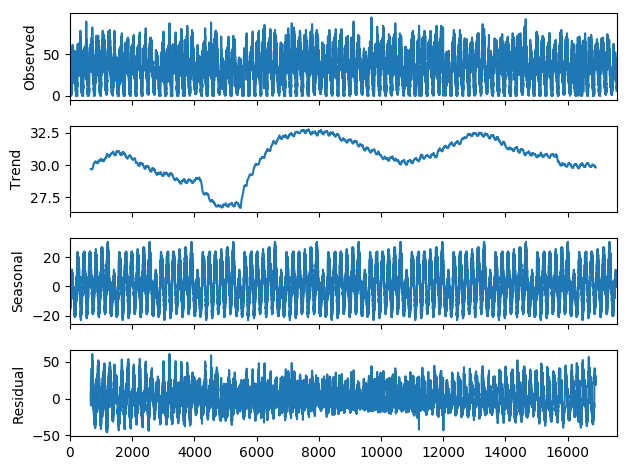

In [82]:
decomposition = sm.tsa.seasonal.seasonal_decompose(univariateData, model='additive', freq=WEEK_SIZE)
fig = decomposition.plot()

plt.rcdefaults()
plt.plot()

## I/O Generation

This phase will form the input (X) and the output (Y)

In [83]:
X_uni, Y_uni= reshape_flow(univariateData, False)

(17546, 24)


In [0]:
if VERBOSITY:
  print(f"X Univariate Shape: {X_uni.shape}")
  print(f"Y Univariate Shape: {Y_uni.shape}")

In [85]:
X_multi, Y_multi= reshape_flow(multivariateData, True)

(17546, 24, 9)


In [0]:
if VERBOSITY:
  print(f"X Multivariate Shape: {X_multi.shape}")
  print(f"Y Multivariate Shape: {Y_multi.shape}")

# Random (Baseline)

This implementation just guess a random number in the [0, 100] interval for every output.

In [0]:
import random as rnd # random

In [0]:
def random_guess_univariate (Y):
  m = max(Y)
  
  expected, observed, times = [], [], []
  pointers = split_dataset(len(Y))
  
  for i, j, k in pointers:
    start = tm.time()
    
    expected.append(Y[j:k])
    observed.append([rnd.randint(0, m) for i in range(k - j)])
    times.append(tm.time() - start)
    
  evaluate(expected, observed, times, "Random Guess")

In [0]:
random_guess_univariate(Y_uni)

# Mean (Baseline)

This implementation just get the mean of every flow value in the input and place it as output.

In [0]:
def mean_univariate (X, Y):
  expected, observed, times = [], [], []
  pointers = split_dataset(len(X))
  
  for i, j, k in pointers:
    start = tm.time()
    
    expected.append(Y[j:k])
    observed.append([np.mean(x) for x in X[j:k]])
    times.append(tm.time() - start)
    
  evaluate(expected, observed, times, "Mean")

In [0]:
mean_univariate(X_uni, Y_uni)

# Random Forest

This implementation is based on [Random Forest Algorithm with Python and Scikit-Learn](https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/)

In [0]:
from sklearn.ensemble.forest import RandomForestRegressor

In [0]:
def random_forest(X, Y):
  model = skl.ensemble.RandomForestRegressor(n_estimators=100, max_features='auto', random_state=0)

  expected, observed, times = [], [], []
  pointers = split_dataset(len(X))
  
  X = X.reshape(X.shape[0], X.shape[1])
  
  for i, j, k in pointers:
    start = tm.time()
    
    model.fit(X[i:j], Y[i:j])
    
    expected.append(Y[j:k])
    observed.append(model.predict(X[j:k]))
    times.append(tm.time() - start)
    
  evaluate(expected, observed, times, "Random Forest")

In [0]:
random_forest(X_uni, Y_uni)

# Support Vector Machine

In [0]:
from sklearn import svm

In [0]:
def support_vector_machine(X,Y):
  model = svm.SVR(gamma='scale', C=1.0, epsilon=0.2)

  expected, observed, times = [], [], []
  pointers = split_dataset(len(X))
  
  X = X.reshape(X.shape[0], X.shape[1])
  
  for i, j, k in pointers:
    start = tm.time()
    
    model.fit(X[i:j], Y[i:j])
    
    expected.append(Y[j:k])
    observed.append(model.predict(X[j:k]))
    times.append(tm.time() - start)
    
  evaluate(expected, observed, times, "SVM")

In [0]:
support_vector_machine(X_uni, Y_uni)

# RNN

In [0]:
from keras.layers import SimpleRNN

In [0]:
def rnn (X, Y, isMulti): 
  name = "RNN Multivariate" if isMulti else "RNN Univariate"
  
  model = Sequential()
  
  model.add(SimpleRNN(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(1))
  
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])
  
  expected, observed, times = [], [], []
  pointers = split_dataset(len(X))
  
  for i, j, k in pointers:
    start = tm.time()
    
    hist = model.fit(X[i:j], Y[i:j], validation_split=0.2, batch_size=64, epochs=15, verbose=0)
    
    expected.append(Y[j:k])
    observed.append(model.predict(X[j:k]))
    times.append(tm.time() - start)
    
    if VERBOSITY:
      plot_history(hist, f"{name} ({str(len(times)).zfill(2)} of {len(pointers)})")
    
  evaluate(expected, observed, times, name)

In [0]:
rnn(X_uni, Y_uni, False)

In [0]:
rnn(X_multi, Y_multi, True)

# LSTM

In [0]:
from keras.layers import LSTM

In [0]:
def lstm (X, Y, isMulti): 
  name = "LSTM Multivariate" if isMulti else "LSTM Univariate"
  
  model = Sequential()
  
  model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(1))
  
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])
  
  expected, observed, times = [], [], []
  pointers = split_dataset(len(X))
  
  for i, j, k in pointers:
    start = tm.time()
    
    hist = model.fit(X[i:j], Y[i:j], validation_split=0.2, batch_size=64, epochs=15, verbose=0)
    
    expected.append(Y[j:k])
    observed.append(model.predict(X[j:k]))
    times.append(tm.time() - start)
    
    if VERBOSITY:
      plot_history(hist, f"{name} ({str(len(times)).zfill(2)} of {len(pointers)})")
    
  evaluate(expected, observed, times, name)

In [0]:
lstm(X_uni, Y_uni, False)

In [0]:
lstm(X_multi, Y_multi, True)

# GRU

In [0]:
from keras.layers import GRU

In [0]:
def gru (X, Y, isMulti): 
  name = "GRU Multivariate" if isMulti else "GRU Univariate"
  
  model = Sequential()
  
  model.add(GRU(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(1))
  
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])

  expected, observed, times = [], [], []
  pointers = split_dataset(len(X))
  
  for i, j, k in pointers:
    start = tm.time()
    
    hist = model.fit(X[i:j], Y[i:j], validation_split=0.2, batch_size=64, epochs=15, verbose=0)
    
    expected.append(Y[j:k])
    observed.append(model.predict(X[j:k]))
    times.append(tm.time() - start)
    
    if VERBOSITY:
      plot_history(hist, f"{name} ({str(len(times)).zfill(2)} of {len(pointers)})")
    
  evaluate(expected, observed, times, name)

In [0]:
gru(X_uni, Y_uni, False)

In [0]:
gru(X_multi, Y_multi, True)

# Results

## Store

In [0]:
store_results()

## Plot

In [0]:
plot_performance_bar(0, 'Seconds', 'Training Time Comparison')

In [0]:
plot_performance_box(0, 'Seconds', 'Training Time Comparison')

In [0]:
plot_performance_bar(1, 'RMSE', 'Root Mean Square Error Comparison')

In [0]:
plot_performance_box(1, 'RMSE', 'Root Mean Square Error Comparison')

In [0]:
plot_performance_bar(2, 'NRMSE', 'Normalized Root Mean Square Error Comparison')

In [0]:
plot_performance_box(2, 'NRMSE', 'Normalized Root Mean Square Error Comparison')

In [0]:
plot_performance_bar(3, 'MAE', 'Max Absolute Error Comparison')

In [0]:
plot_performance_box(3, 'MAE', 'Max Absolute Error Comparison')

In [0]:
plot_performance_bar(4, 'R2', 'R Squared Comparison')

In [0]:
plot_performance_box(4, 'R2', 'R Squared Comparison')

In [0]:
plot_performance_bar(5, 'HR', 'Hit Ratio Comparison')

In [0]:
plot_performance_box(5, 'HR', 'Hit Ratio Comparison')

# Compare By Window

In [0]:
def plot_results_by_window_split():
  path = f"{TCC_PATH}plots/window_comparison"
  models = [*comparison_data[0]['results']]
  print(models)
  
  for model in models:
    datapoints = [result['results'][model]['NRMSE'] for result in comparison_data]
    plt.plot(datapoints)

  plt.title('Windows Size for Training Comparison')
  plt.ylabel('NRMSE')
  plt.xlabel('Window Size')
  plt.legend(models, loc='upper left')
  plt.rcdefaults()

  plt.savefig(path + ".png", bbox_inches='tight')
  plt.savefig(path + ".pdf")

  plt.close('all')

In [0]:
def compare_results_by_window_split():
  global SET_SPLIT
  global result_data
  global comparison_data
  
  splitting_windows = [0.20, 0.25, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
  
  result_data = {
      'results': {},
      'meta': {}
  }
  comparison_data = []

  for split in splitting_windows:
    SET_SPLIT = split

    random_guess_univariate(Y_uni)
    mean_univariate(X_uni, Y_uni)
    random_forest(X_uni, Y_uni)
    support_vector_machine(X_uni, Y_uni)
    rnn(X_uni, Y_uni, False)
    rnn(X_multi, Y_multi, True)
    lstm(X_uni, Y_uni, False)
    gru(X_uni, Y_uni, False)
    gru(X_multi, Y_multi, True)
    
    print([*result_data['results']])

    comparison_data.append(copy.deepcopy(result_data))


  store_comparisons()

In [147]:
compare_results_by_window_split()

['Random Guess', 'Mean']
['Random Guess', 'Mean']
['Random Guess', 'Mean']
['Random Guess', 'Mean']


In [148]:
plot_results_by_window_split()

['Random Guess', 'Mean']


# Observations:

+ For the evaluation of the RNN and it's variations was used the Walking Forward methodology so that we had many test sessions and all training sessions where the same size [[1]](https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9)